# BioscrapeCOBRA: a hyrid composite of chemical reaction networks with flux balance analysis

## Overview
This notebook combines a chemical reaction network model with a flux balance analysis model, and a physics engine

* SBML
* BiGG model

In [1]:
#@title install vivarium libraries

#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.5
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

'\n%%capture\n!pip install git+https://github.com/vivarium-collective/vivarium-notebooks\n!pip install vivarium-core==0.1.5\n!pip install vivarium-cobra==0.0.6\n!pip install vivarium-pymunk==0.0.2\n!pip install vivarium-bioscrape\n'

In [2]:
#@title imports
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, Deriver, Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# import processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

# vivarium-cobra processes
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)

# vivarium-bioscrape processes
from vivarium_bioscrape.processes.bioscrape import Bioscrape


In [3]:
# plotting function for metabolism output
def plot_metabolism(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
#     ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

# Flux Balance Analysis with COBRA

 * This process is a wrapper for the popular FBA solver [COBRA](https://cobrapy.readthedocs.io/en/latest/).
 * Metabolism is initialized with a [BiGG metabolic model](http://bigg.ucsd.edu) called *iAF1260b*, which has 2382 reactions, 1261 genes, and 166 metabolites.

In [4]:
compartment_in_experiment
# get the configuration for the iAF1260b BiGG model
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})
config = {'cobra': cobra_config}   

# load it into DynamicFBA
metabolism = CobraComposite(config)

# get the model's initial state
initial_state = metabolism.initial_state({}) 

# run simulation
sim_settings = {
    'initial_state': initial_state,
    'total_time': 2500}
cobra_timeseries = simulate_compartment_in_experiment(metabolism, sim_settings)


Experiment ID: 2be4727a-64e7-11eb-bef0-6c2b5976b3a5
Created: 02/01/2021 at 15:42:40
Completed in 27.17 seconds


volume growth: 1.9537412863469115
mass growth: 1.9537412863469115


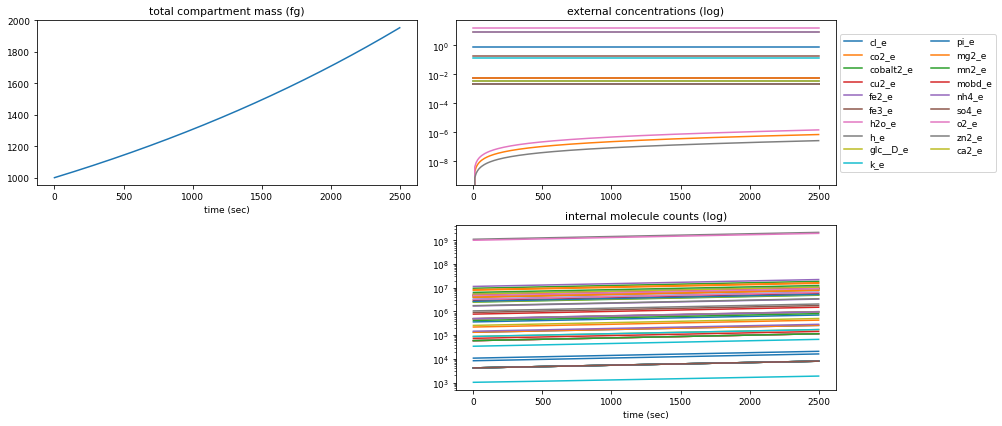

In [5]:
print_growth(cobra_timeseries['global'])
plot_metabolism(cobra_timeseries)

# Chemical Reaction Network with SBML 

In [6]:
time_step = 1
total_time = 2500

# initialize Bioscrape process
bioscrape_config = {
    'sbml_file': 'LacOperon_deterministic.xml',
    'time_step': time_step}
bioscrape_process = Bioscrape(bioscrape_config)

# initial state
initial_state = bioscrape_process.initial_state()

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries = simulate_process_in_experiment(bioscrape_process, settings)

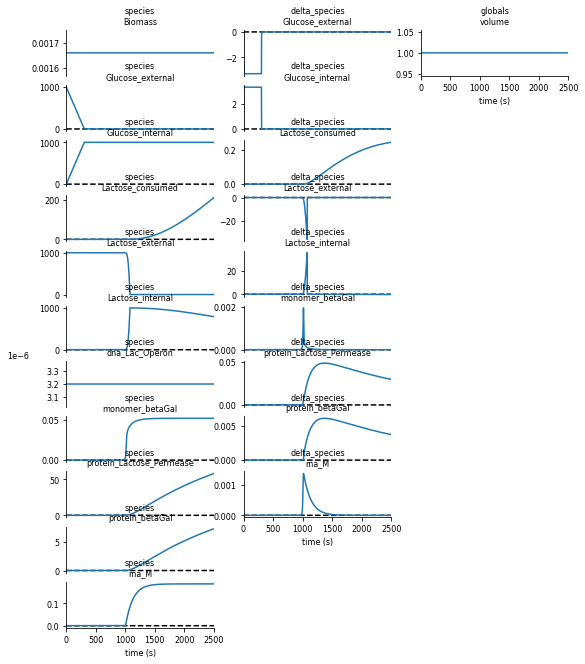

In [7]:
fig = plot_simulation_output(bioscrape_timeseries)

# Multibody physics with pymunk

In [8]:
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import agent_body_config, volume_from_length
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors,
)
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

In [9]:
total_time = 120
n_agents = 2
agent_ids = [
    str(agent_id)
    for agent_id in range(n_agents)]

# configure the multibody process
multibody_bounds = [40, 40]
multibody_config = {
    'bounds': multibody_bounds}
body_config = {
    'bounds': multibody_bounds,
    'agent_ids': agent_ids}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4, 1),
        total_time=total_time,
        experiment_settings=experiment_settings)

multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

In [10]:
try:
    time_index = 1
    time_indices = np.array([time_index])
    time_vec = list(agents.keys()) 

    # time_indices = np.round(np.linspace(0, len(time_vec) - 1, n_snapshots)).astype(int)
    snapshot_times = [time_vec[i] for i in time_indices]

    # get fields id and range
    multibody_field_range = get_field_range(fields, time_vec)

    # get agent ids
    multibody_agent_colors = get_agent_colors(multibody_agents)


    time_index_range = len(time_vec) -1

    def plot_single_snapshot(t_index):   
        time_indices = np.array([t_index])
        snapshot_time = [time_vec[t_index]]
        fig = make_snapshots_figure(
            time_indices=time_indices,
            snapshot_times=snapshot_time,
            agents=multibody_agents,
            agent_colors=multibody_agent_colors,
            fields=multibody_fields,
            field_range=multibody_field_range,
            n_snapshots=1,
            bounds=multibody_bounds,
            default_font_size=12,
            plot_width=6,
        )
except NameError as e:
    print("Something isn't working! Error:", e)

Something isn't working! Error: name 'agents' is not defined


In [11]:
try:
    interactive_plot = interactive(
        plot_single_snapshot, 
        t_index=widgets.IntSlider(min=0, max=time_index_range, step=1, value=0))
    interactive_plot
except NameError as e:
    print("Something isn't working! Error:", e)

Something isn't working! Error: name 'plot_single_snapshot' is not defined


# BioscrapeCOBRA: a CRN/FBA Composite

This also includes several adaptor "Deriver" Processes, such as FluxDeriver and BiomassAdaptor

* BiomassAdaptor demonstrates vivarium units, and also the use of a Deriver as an adaptor between Processes

## Flux Deriver

A Deriver is a kind of Process which can be used to convert values of one store into another type of value in another store. For example, this FluxDeriver converts amounts of species and changes in amounts of species to instantaneous fluxes.

This FluxDeriver is used in the composite to convert the changes of Lactose and Glucose from the CRN model into flux-bounds for the FBA model. In these cases "deltas" (changes in Species) are converted to fluxes by dividing by the timestep.

This FluxDeriver is also used to convert changes in biomass, output from the FBA model, into a dilution rate constant used by the CRN. This flux is computered differently because the change in biomass each timestep is not stored. Additionally, dilution rate must be calculated as a percentage of the current amount, not absolute flux, and be non-negative.

In [12]:
class FluxDeriver(Deriver):
    """ Bioscrape delta species to fluxes for constraining COBRA """
    
    defaults = {
        'time_step': 1,
        'flux_keys': [], #Used to compute fluxes from discrete changes (assumed to be deltas)
        'flux_options' : {} #key --> list of options: 'percent', 'amount', 'positive', 'ignore zeros'
    }

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'deltas': {
                flux_key: {
                    '_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'amounts': {
                flux_key: {
                    '_default':0.0,
                    '_updater':'set'}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {
                    '_updater': 'set',
                    '_emit':True }
                for flux_key in self.parameters['flux_keys']
            }
        }

    def next_update(self, timestep, states):
        deltas = states['deltas']
        amounts = states['amounts']
        options = self.parameters['flux_options']
        dt = self.parameters['time_step']
        
        if not hasattr(self, 'prev_amounts'):
            self.prev_amounts = dict(amounts)
        
        update = {}
        update['fluxes'] = {}
        
        for key in self.parameters['flux_keys']:
            skip_update = False
            #Set delta
            if key not in options or 'amount' not in options[key]:
                delta = deltas[key]
            elif 'amount' in options[key]:
                delta = amounts[key]-self.prev_amounts[key]
            
            #Apply options
            #percent calculates flux as a percent of the previous amount
            if key in options and 'percent' in options[key]:
                if self.prev_amounts[key] == 0: #to avoid dividing by 0
                    skip_update = True
                else:
                    delta = delta/(self.prev_amounts[key])
                
            #positive sets all negative fluxes to 0
            if  key in options and 'positive' in options[key] and delta < 0: 
                delta = 0
                
            #if delta is 0, does not update this flux
            #this is a hack which allows for variable update times between Cobra and Bioscrape
            if key in options and 'ignore zeros' in options[key] and delta == 0:
                skip_update = True   
            
            if not skip_update:
                update['fluxes'][key] = delta / dt
            
        self.prev_amounts = amounts
        return update

## BiomassAdaptor Deriver

This adaptor is used to do unit conversion between the mass output from cobra and a Species used in the Bioscrape model to represent biomass.

In [13]:
class BiomassAdaptor(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'input_volume_units':1.0 * units.fL,
        'output_mass_units':1.0 *units.mmolar,
        'output_volume_units':1.0 *units.fL,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * units.fg,
                },
                'volume': {
                    '_default': 1.0 * units.fL}
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #Concentration = mass/molecular_weight/characteristic volume
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_conc = mass/self.config['mass_species_molecular_weight']/(1*self.config['output_volume_units'])        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_conc.to(self.config['output_mass_units']).magnitude
                }
            }
        return update
    

# BioscrapeCOBRA Composite configurations

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

TODO:
    * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
    * import of Glucose is also in terms of 'Biomass' species
    * stochastically, it is in counts. Volume
    * logic for counts/concentrations if stochastic/deterministic
    * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        But don't let Bioscrape update them. Only use FBA's resulting uptake.


In [14]:
#choose the SBML file and set other bioscrape parameters
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,}

# set cobra constrained reactions config
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})

#set up the config for the FluxDeriver
flux_config = {
    'flux_keys': [ #there are three fluxes keys, one for each flux computed
        'Lactose_consumed', 'Glucose_internal', 'biomass',
        ],
    'flux_options' : { #many options are toggled to get the correct biomass --> diluton rate conversion
        'biomass': [
            'amount', 'percent', 'positive', 'ignore zeros',
        ]
    }
}

#Here we override the default ports schema of the Biomass species and the k_dilution rate in Bioscrape.
#This is done so they can be set by the Derivers connected to mass and mass flux from Cobra.
schema_override = {
    'bioscrape': {
        'species': {
            'Biomass': { 
                '_updater': 'set'  #override bioscrape ('species', 'Biomass') with a 'set' updater
            }
        },
        'rates':{
            'k_dilution__':{
                '_emit':True, #k_dilution should be emitted so it can be plotted
                '_updater':'set'
            }
        }
    }
}

In [15]:
class BioscrapeCOBRA(Composite):

    defaults = {
        'bioscrape': deterministic_bioscrape_config,
        'cobra': cobra_config,
        'flux_deriver': flux_config,
        'divide_on': False, # is division turned on?
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2000 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
         '_schema': schema_override,
        'stochastic':False
    }

    def generate_processes(self, config):

        bioscrape_process = Bioscrape(config['bioscrape'])
        cobra_process = DynamicFBA(config['cobra'])
        flux_deriver = FluxDeriver(config['flux_deriver'])

        # logic for counts/concentrations if stochastic/deterministic
        if config['bioscrape']['stochastic']:
            pass

        processes = {
            'bioscrape': bioscrape_process,
            'cobra': cobra_process,
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
            'flux_deriver': flux_deriver,
            'biomass_adaptor': BiomassAdaptor(),
        }
        if config['divide_on']:
            # division config
            daughter_path = config['daughter_path']
            agent_id = config['agent_id']
            division_config = dict(
                config.get('division', {}),
                daughter_path=daughter_path,
                agent_id=agent_id,
                generator=self)

            processes.update({
                'divide_condition': DivideCondition(config['divide_condition']),
                'division': MetaDivision(division_config)
            })
        return processes

    def generate_topology(self, config):

        topology = {
            'bioscrape': {
                # all species go to a species store on the base level,
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..', 'globals', 'biomass'),
                },
                'delta_species': ('delta_species',),
                'rates': {
                    '_path' : ('rates',),
                    #'k_dilution__': ('..', 'flux_bounds', 'k_dilution__'),
                },
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('globals',),
            },
            'flux_deriver': {
                'deltas': ('delta_species',),
                'amounts': ('globals',),
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'
                
                'fluxes':
                    {
                        '_path': ('flux_bounds',),
                        'Lactose_consumed': ('EX_lac__D_e',),
                        'Glucose_internal': ('EX_glc__D_e',),
                        'biomass':('k_dilution__',)
                    }
            },
            'mass_deriver': {
                'global': ('globals',),
            },
            'volume_deriver': {
                'global': ('globals',),
            },
            'biomass_adaptor': {
                'input': ('globals',),
                'output': ('globals',),
            }
        }
        
        #Ports added only in the deterministic case
        if not config['stochastic']:
            # connect biomass flux to the dilution rate
            topology['flux_deriver']['fluxes'].update({'biomass':('k_dilution__',)})
            topology['bioscrape']['rates'].update({'k_dilution__': ('..', 'flux_bounds', 'k_dilution__')})
            
        #Ports added only in the stochastic case
        else:
            pass
        
        if config['divide_on']:
            agents_path = config['agents_path']

            # connect divide_condition to the mass variable
            topology.update({
                'divide_condition': {
                    'variable': ('globals', 'mass',),
                    'divide': ('globals', 'divide',),
                },
                'division': {
                    'global': ('globals',),
                    'agents': agents_path,
                },
            })
        return topology

In [16]:
bioscrape_cobra_composite = BioscrapeCOBRA({})

#experiment = compartment_in_experiment(bioscrape_cobra_composite)
#pp(experiment.state.get_config(True))



In [17]:
# get initial state
initial_state = bioscrape_cobra_composite.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 500}
bioscrape_cobra_output = simulate_compartment_in_experiment(
    bioscrape_cobra_composite, 
    settings)

#plt.figure()
#plt.plot(bioscrape_cobra_output['time'], bioscrape_cobra_output['rates']['k_dilution__'])


Experiment ID: 430f79ee-64e7-11eb-876d-6c2b5976b3a5
Created: 02/01/2021 at 15:43:19


C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 9.37 seconds


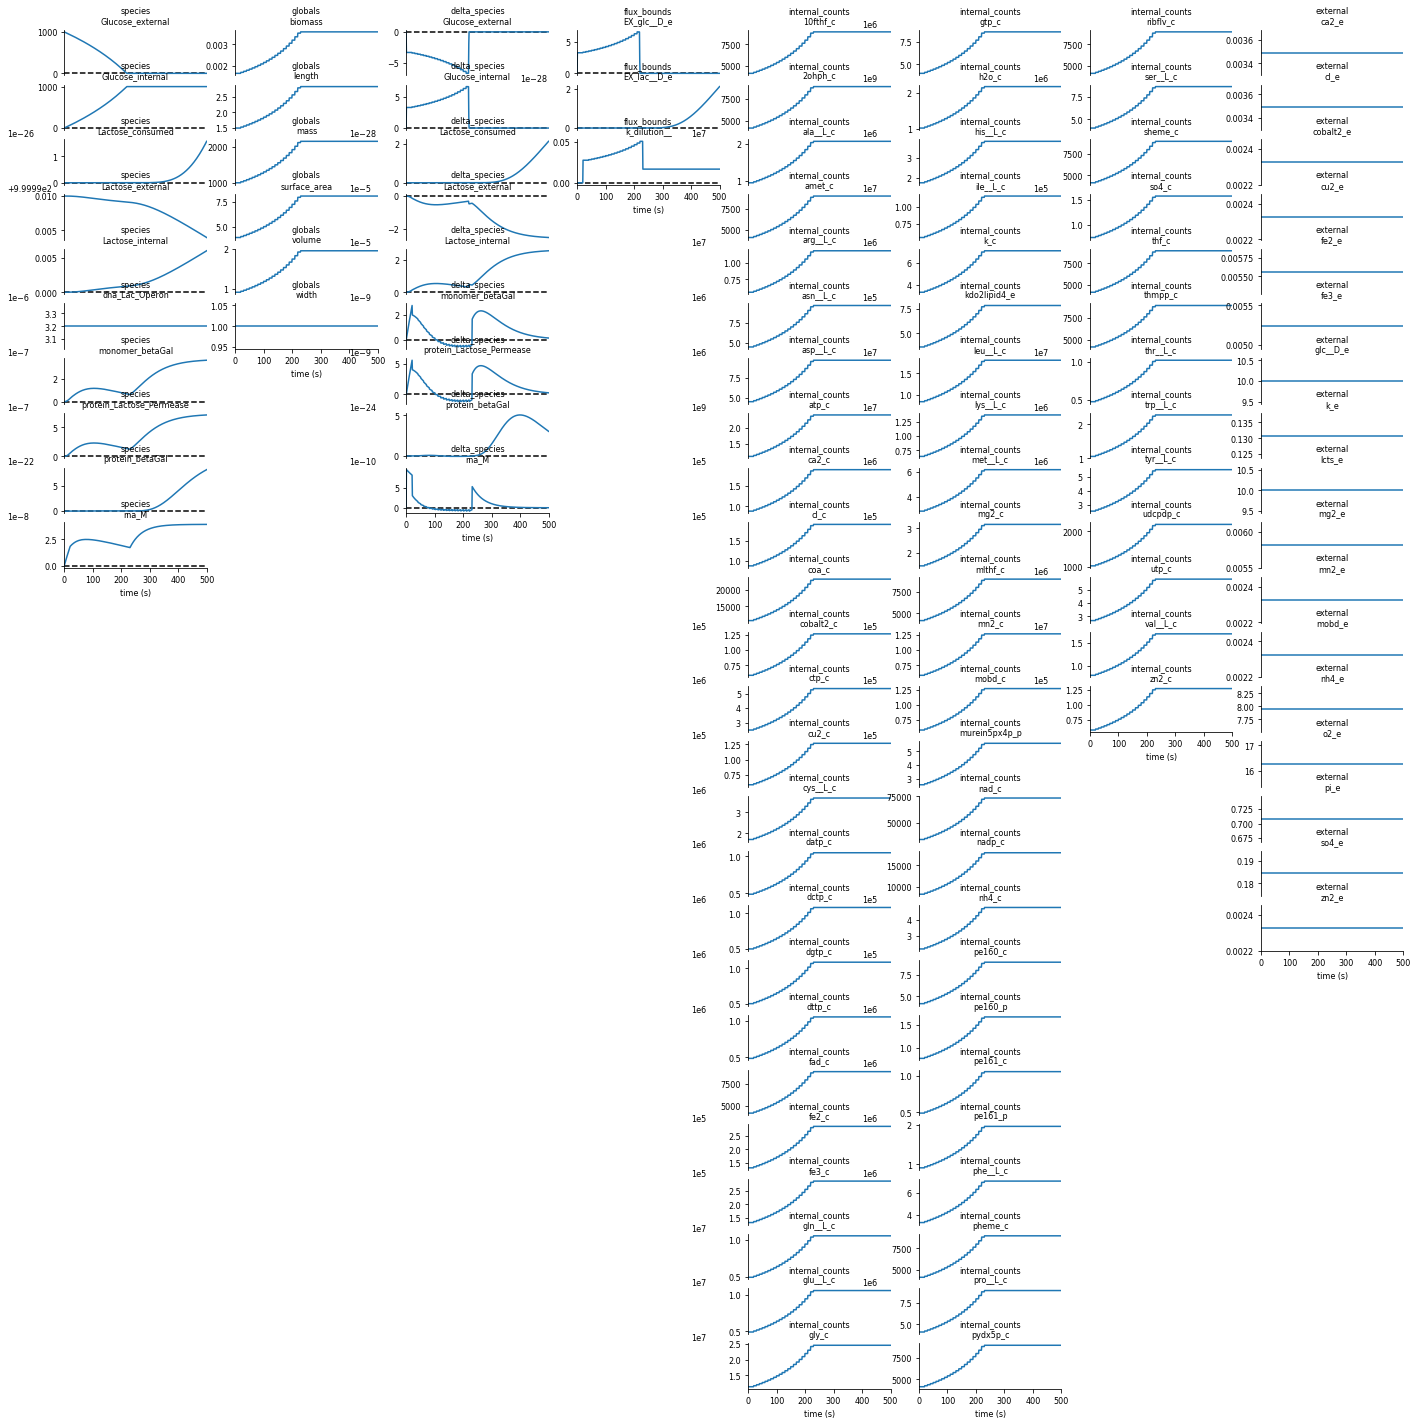

In [18]:
fig = plot_simulation_output(bioscrape_cobra_output)

# Stochastic Bioscrape-Cobra

Changes required for Stochastic Model
* New CRN Model without dilution and with initial conditions in counts instead of concentration
    * this means "k_dilution__" porting needs to removed from the topology
* BiomassDeriver converts to counts instead of concentration
* FluxDeriver run in "stochastic" mode where flux is averaged over the cobra update time-frame.

# Turning on Division

In [19]:
total_time = 2500

agent_id = '1'
division_config = {
    'divide_on': True,
    'agent_id': agent_id,
    'agents_path': ('..', '..', 'agents',),
}
division_composite = BioscrapeCOBRA(division_config)

# initial state
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

# run simulation
# simulate
settings = {
    'outer_path': ('agents', agent_id,),
    'initial_state': initial_state,
    'experiment_id': 'division'}
division_experiment = compartment_in_experiment(
    division_composite,
    settings=settings,
    initial_state=initial_state)




Experiment ID: division
Created: 02/01/2021 at 15:43:38


In [20]:
# run the experiment and extract the data
division_experiment.update(total_time)
division_output = division_experiment.emitter.get_data_unitless()

C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 109.92 seconds


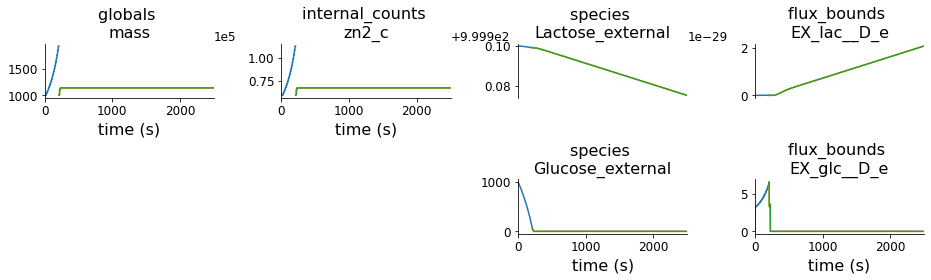

In [21]:
plot_settings = {
#     'skip_paths': [('external',)]
    'include_paths': [
        ('globals', 'mass'),
        ('species', 'Glucose_external'),
        ('species', 'Lactose_external'),
        ('flux_bounds', 'EX_glc__D_e'),
        ('flux_bounds', 'EX_lac__D_e'),
        ('internal_counts', 'zn2_c'),
        ],
}
fig = plot_agents_multigen(
    division_output,
    settings=plot_settings,
)

# Simulate BioscrapeCOBRA in a Spatial Environment with pymunk
 * We here plug BioscrapeCOBRA into an environmental composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).

In [22]:
from vivarium_multibody.composites.lattice import Lattice, make_lattice_config


# declare configurations
agent_id = '1'
lattice_bounds = [20, 20]
env_config = {
    'time_step': 60,
    'bounds': lattice_bounds}

# declare the hierarchy
hierarchy = {
    FACTORY_KEY: {
        'type': Lattice,
        'config': make_lattice_config()},
    'agents': {
        agent_id: {
            FACTORY_KEY: {
                'type': BioscrapeCOBRA,
                'config': {
                    'divide_on': True,
                    'agent_id': agent_id,
                    'agents_path': ('..', '..', 'agents',),
                }}}}}


# configure experiment with helper function compose_experiment()
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

experiment_settings = {
    'initial_state': initial_state,
    'experiment_id': 'spatial_environment'}

OSError: [WinError 126] The specified module could not be found

In [ ]:
# make the experiment
spatial_experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
spatial_experiment.update(1000)

# retrieve the data
spatial_data = spatial_experiment.emitter.get_data_unitless()
agents, fields = format_snapshot_data(spatial_data)

In [ ]:
fig = plot_snapshots(
    bounds=lattice_bounds, 
    agents=agents, 
    fields=fields)